### SELF-SUPERVISED DENOISING: PART FIVE
# Automated blind-mask design with eXplainable AI (XAI) 
### _Authors: [Claire Birnie](https://cebirnie92.github.io/) and [Matteo Ravasi](https://mrava87.github.io), KAUST_


--------------

**Work smarter, not harder...**

This is the fifth tutorial in our self-supervised seismic denoising tutorial series. So far we have covered how blind-masks can be used for coherent noise suppression, but the proposed procedure requires prior knowledge of the relationship of noise across pixels to determine the noise mask. In this tutorial, we will delve into the world of eXplainable AI and use the knowledge of what pixels the network itself uses in order to automatically build noise masks.


The tutorial notebooks were originally designed to supplement the course slides. However, it should still be easy to follow provided you have read the reference paper and understood the key concepts.


## Tutorial Objectives

On completion of this tutorial, you will have denoised a field seismic section using the 


## Prior Requisites:
Complete tutorial 1 or 2 and copy-paste your training and evaluate functions into ssdn_functions.py. If you have not completed the aforementioned tutorials, at the stages in this tutorial where those functions are required you will be prompted to copy-paste the skeleton code from tutorial 1 and complete it. As a last resort, copy the pre-written functions from the solutions directory. Writing the code is a great way to ensure you fully understand the methodology therefore we do not recommend copy-pasting from the solutions directory.

## Reference Paper:
Birnie, C. and Ravasi, M., 2024. Explainable artificial intelligence‐driven mask design for self‐supervised seismic denoising. Geophysical Prospecting.

[[Paper Link]](https://doi.org/10.1111/1365-2478.13480)

## Key Concepts Recap
#### _N2V: Random Noise Suppression_
In this series of tutorials, we implement the Noise2Void methodology of [Krull et al., [2019]](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf) for self-supervised denoising using blind-spot networks. The methodology involves performing a pre-processing step that identifies a number of 'active' pixels and replaces their original noisy values with the value of a neighbouring pixel. This processed data becomes the input to the neural network with the original noisy image being the network's target. However, unlike in most NN applications, the loss is not computed across the full predicted image, but only at the active pixel locations. Under the assumption of i.i.d. noise, the network cannot predict the noise element of the active pixels' original values and, therefore, the network only learns to recreate the signal element, resulting in a denoised image.  

#### _StructN2V: Coherent Noise Suppression_
N2V requires noise to be independent, however this is a rare occurrence. [Broaddus et al., [2020]](https://ieeexplore.ieee.org/document/9098336) proposed StructN2V to extend the blind-spot methodology to coherent noise suppression. To do so, first, the raw data is evaluated to determine the relationship between noise elements across pixels. This analysis is used to build a noise mask that is designed to hide any pixels which exhibit coherency between their noise elements and the noise of the central pixel. Once the mask is designed, active pixels are selected (like in the original N2V methodology) however now not only is the central pixel's value changed, as is all pixels that fall within the noise mask. As the mask covers neighbouring pixels, the  values used for corruption are typically drawn from a predefined distribution.  Corrupting all pixels within the mask region ensures the input to the network has no useable information for predicting the noise component of the central pixels. As before, the loss is only computed at the active pixels locations. In theory, the network learns to use pixels out with the masked area to recreate the central pixel's value.


#### _Jacobian Analysis: eXplainable AI_
For bias-free CNNs, the relationship between a single input and output is **locally linear**, where the output forms the matrix multiplication between the input and the Jacobian matrix of the neural network. As such, to determine the strength input pixels have on a single output pixel's predicted value, one can compute and extract the corresponding row of the Jacobian matrix. Knowledge of heavily contributing pixels can be used to automate (or guide) the blind-mask design. 


***

In [1]:
# Import necessary basic packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Import necessary torch packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Import our pre-made functions which will keep the notebook concise
# These functions are independent to the blindspot application however important for the data handling and 
# network creation/initialisation
from unet import UNet
from tutorial_utils import regular_patching_2D, add_bandlimited_noise, weights_init, set_seed, make_data_loader, plot_corruption, plot_training_metrics, plot_synth_results



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# These are functions that we wrote in tutorials 1-3 
from tutorial_functions import multi_active_pixels, n2v_train, n2v_evaluate

In [3]:
# Some general plotting parameters so we don't need to keep adding them later on
cmap='RdBu'
vmin = -0.25
vmax = 0.25

# For reproducibility purposes we set random, numpy and torch seeds
set_seed(42) 

True

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the public data folder: https://exrcsdrive.kaust.edu.sa/exrcsdrive/index.php/s/vjjry6BZ3n3Ewei

with password: `kaust`

If the folder is no longer public, this is likely due to expired rights. Please email: cebirnie[at]kaust.edu.sa to request access. 

In this instance I have downloaded the file and added to a folder in this repository title 'data'.

In [4]:
d = np.load("../data/Hess_PostStackSection.npy")

# Check data dimensions
print(d.shape)

(196, 452)


#### Plot the data to see what it looks like

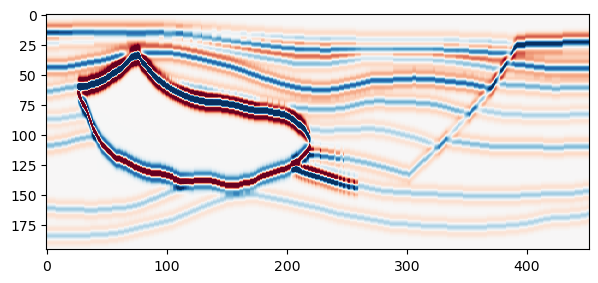

In [5]:
plt.figure(figsize=[7,5])
plt.imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)

### Add noise

As we can see from above, the data which you loaded in is the noise-free synthetic. This is great for helping us benchmark the results however we are really interested in testing the denoising performance of blind-spot networks there we need to add some noise that we wish to later suppress. 

In [6]:
noisydata, _ = add_bandlimited_noise(d, sc=0.1)

#### Plot the noisy data to see what it looks like in comparison to the clean

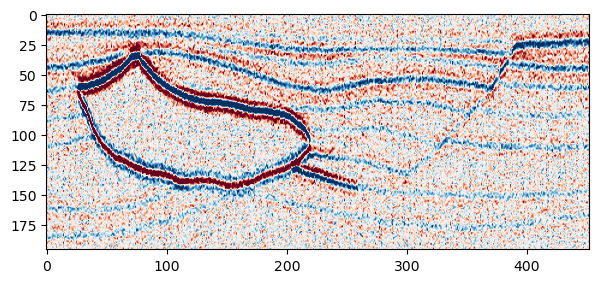

In [7]:
plt.figure(figsize=[7,5])
plt.imshow(noisydata, cmap=cmap, vmin=vmin, vmax=vmax)

### Patch data

At the moment we have a single image that we wish to denoise however to train the network we need to give it multiple data examples. Therefore, following common computer vision methodology, we will select random patches from the data for the networks training. 

Our patch implementation involves first regularly extracting patches from the image and then shuffling the patches such that they are in a random order. Later at the training stage these patches will be split into train and test dataset.

In [8]:
# Regularly extract patches from the noisy data
noisy_patches = regular_patching_2D(noisydata, 
                                    patchsize=[32, 32], # dimensions of extracted patch
                                    step=[4,6], # step to be taken in y,x for the extraction procedure
                                   )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

Extracting 2870 patches


#### Visualise the training patches

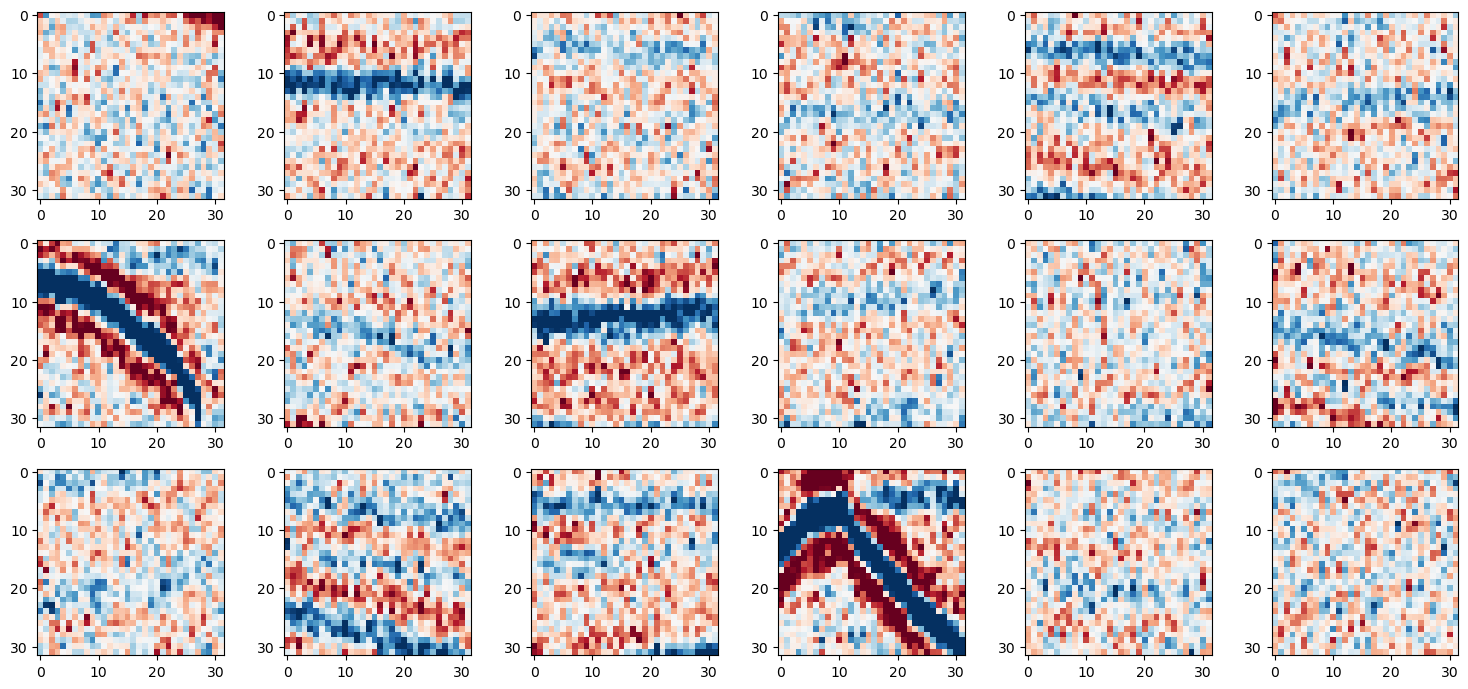

In [9]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

***

# Step Two - Blindspot corruption of training data

Now we have made our noisy data into patches such that we have an adequate number to train the network, we now need to pre-process these noisy patches prior to being input into the network. 

Our implementation of the preprocessing involves:

    - selecting the active pixels 
    - selecting the neighbourhood pixel for each active pixel, which it will take the value of
    - replacing each active pixels' value with its neighbourhood pixels' value
    - creating a active pixel 'mask' which shows the location of the active pixels on the patch
    
The first three steps are important for the pre-processing of the noisy patches, whilst the fourth step is required for identifying the locations on which to compute the loss function during training.

#### TO DO:  CHECK THE CORRUPTION FUNCTION WORKS

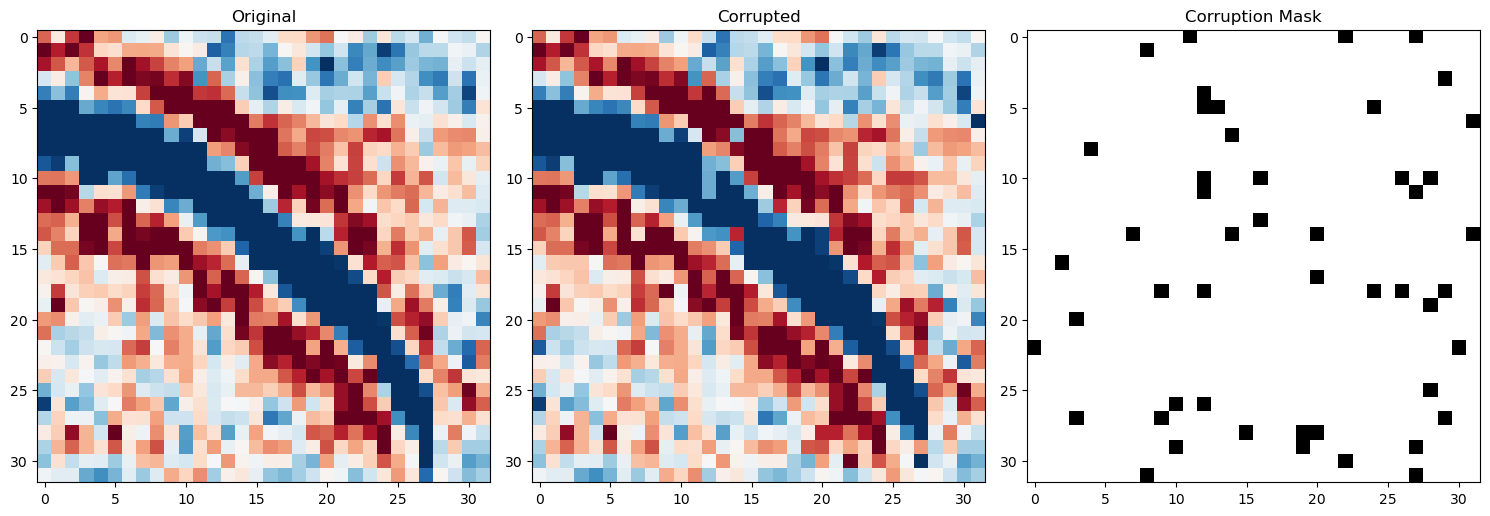

In [10]:
# Input the values of your choice into your pre-processing function
crpt_patch, mask = multi_active_pixels(noisy_patches[6], 
                                       num_activepixels=50, 
                                       neighbourhood_radius=5, 
                                      )

# Use the pre-made plotting function to visualise the corruption
fig,axs = plot_corruption(noisy_patches[6], crpt_patch, mask)

#### TO DO: SELECT THE NUMBER OF ACTIVE PIXELS (AS PERCENTAGE)

In the original N2V examples the authors use between 0.5 and 2% for the number of active pixels within a patch.

In Birnie et al., 2021 where they use this methodology for the suppression of white, Gaussian noise, the authors use 0.2%. However, in their example they have substantially more training patches.

Number of active pixels selected: 
 2.00 percent equals 20 pixels


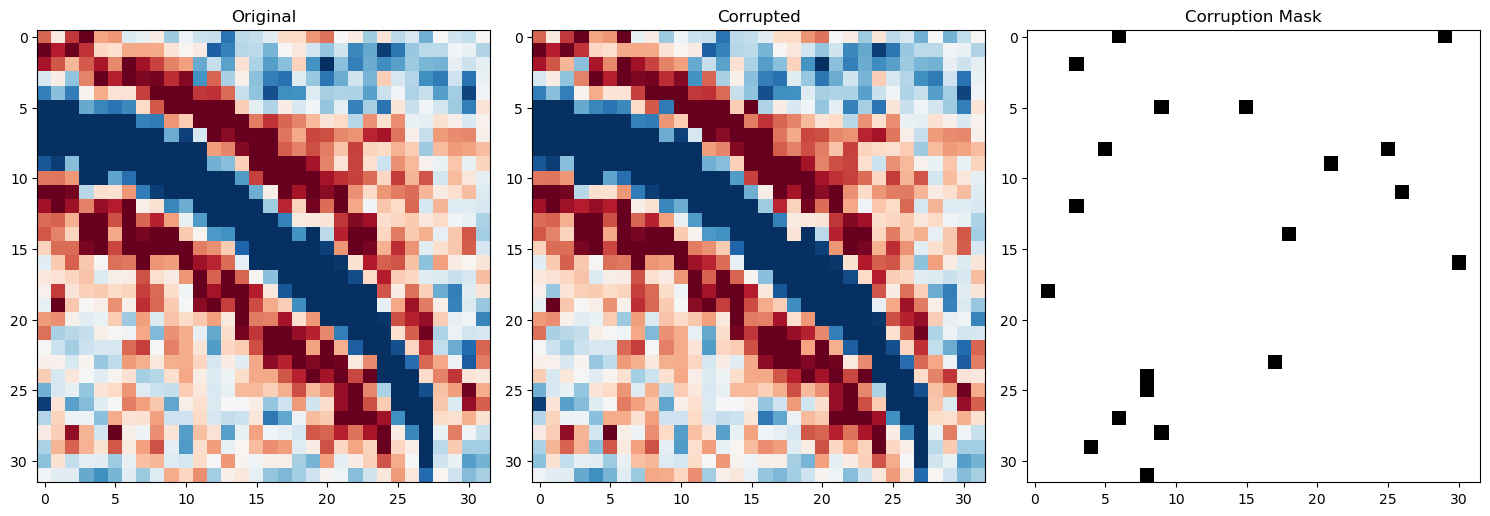

In [11]:
# Choose the percent of active pixels per patch
perc_active = 2

# Compute the total number of pixels within a patch
total_num_pixels = noisy_patches[0].shape[0]*noisy_patches[0].shape[1]
# Compute the number that should be active pixels based on the choosen percentage
num_activepixels = int(np.floor((total_num_pixels/100) * perc_active))
print("Number of active pixels selected: \n %.2f percent equals %i pixels"%(perc_active,num_activepixels))

# Input the values of your choice into your pre-processing function
crpt_patch, mask = multi_active_pixels(noisy_patches[6], 
                                       num_activepixels=num_activepixels, 
                                       neighbourhood_radius=5, 
                                      )

# Visulise the coverage of active pixels within a patch
fig,axs = plot_corruption(noisy_patches[6], crpt_patch, mask)

***

# Step three - Set up network

In the N2V application of Krull et al., 2018, the network is not specially tailored to the blindspot task. As such, in theory any network could be used that goes from one input image to another of the same size.

In this example, like in Krull et al., 2018 and Birnie et al., 2021's seismic application, we will use a standard UNet architecture. As the architecture is independent to the blind-spot denoising procedure presented, it will be created via functions as opposed to being wrote within the notebook. 

In [12]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
elif torch.backends.mps.is_available(): 
    print("M1 installed! Running on M1!")
    device = torch.device("mps")
else:
    print("No GPU available!")

M1 installed! Running on M1!


#### Build the network

In [13]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(weights_init) 

/Users/clairebirnie/Documents/Projects/TEACHING/SelfSupervisedDenoising_2024TutorialMaterial/Solutions/tutorial_utils.py:267: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/Users/clairebirnie/Documents/Projects/TEACHING/SelfSupervisedDenoising_2024TutorialMaterial/Solutions/tutorial_utils.py:268: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


#### Select the networks training parameters

In [14]:
lr = 0.0001  # Learning rate
criterion = nn.MSELoss()  # Loss function
optim = torch.optim.Adam(network.parameters(), lr=lr)  # Optimiser

***

# Step four - Network Training

Now we have successfully built our network and prepared our data - by patching it to get adequate training samples and creating the input data by selecting and corrupting the active pixels. We are now ready to train the network.

Remember, the network training is slightly different to standard image processing tasks in that we will only be computing the loss on the active pixels.

#### TO DO: DEFINE TRAINING PARAMETERS

In [15]:
# Choose the number of epochs
n_epochs = 100  # most recommend 150-200 for random noise suppression 

# Choose number of training and validation samples
n_training = 2048
n_test = 512

# Choose the batch size for the networks training
batch_size = 128

In [16]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

#### TO DO: COMPLETE TRAINING LOOP BY INCORPORATING ABOVE FUNCTIONS

In [17]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        
        # TO DO: USE ACTIVE PIXEL FUNCTION TO COMPUTE INPUT DATA AND MASKS
        # Hint: One line of code
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                               neighbourhood_radius=5, 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    # TO DO: Incorporate previously wrote n2v_train function
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    # TO DO: Incorporate previously wrote n2v_evaluate function
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.75it/s]


Epoch 0, 
    Training Loss 0.0002,     Training Accuracy 0.1081, 
    Test Loss 0.0001,     Test Accuracy 0.0836 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


Epoch 1, 
    Training Loss 0.0001,     Training Accuracy 0.0793, 
    Test Loss 0.0001,     Test Accuracy 0.0751 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.65it/s]


Epoch 2, 
    Training Loss 0.0001,     Training Accuracy 0.0730, 
    Test Loss 0.0001,     Test Accuracy 0.0711 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


Epoch 3, 
    Training Loss 0.0001,     Training Accuracy 0.0691, 
    Test Loss 0.0001,     Test Accuracy 0.0674 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.98it/s]


Epoch 4, 
    Training Loss 0.0001,     Training Accuracy 0.0651, 
    Test Loss 0.0001,     Test Accuracy 0.0632 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.45it/s]


Epoch 5, 
    Training Loss 0.0001,     Training Accuracy 0.0615, 
    Test Loss 0.0001,     Test Accuracy 0.0600 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.82it/s]


Epoch 6, 
    Training Loss 0.0001,     Training Accuracy 0.0583, 
    Test Loss 0.0001,     Test Accuracy 0.0567 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 7, 
    Training Loss 0.0001,     Training Accuracy 0.0556, 
    Test Loss 0.0001,     Test Accuracy 0.0541 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.82it/s]


Epoch 8, 
    Training Loss 0.0000,     Training Accuracy 0.0532, 
    Test Loss 0.0001,     Test Accuracy 0.0527 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.06it/s]


Epoch 9, 
    Training Loss 0.0000,     Training Accuracy 0.0504, 
    Test Loss 0.0000,     Test Accuracy 0.0497 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.42it/s]


Epoch 10, 
    Training Loss 0.0000,     Training Accuracy 0.0482, 
    Test Loss 0.0000,     Test Accuracy 0.0476 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.00it/s]


Epoch 11, 
    Training Loss 0.0000,     Training Accuracy 0.0460, 
    Test Loss 0.0000,     Test Accuracy 0.0450 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.51it/s]


Epoch 12, 
    Training Loss 0.0000,     Training Accuracy 0.0441, 
    Test Loss 0.0000,     Test Accuracy 0.0435 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.03it/s]


Epoch 13, 
    Training Loss 0.0000,     Training Accuracy 0.0430, 
    Test Loss 0.0000,     Test Accuracy 0.0423 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.10it/s]


Epoch 14, 
    Training Loss 0.0000,     Training Accuracy 0.0419, 
    Test Loss 0.0000,     Test Accuracy 0.0416 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.33it/s]


Epoch 15, 
    Training Loss 0.0000,     Training Accuracy 0.0416, 
    Test Loss 0.0000,     Test Accuracy 0.0416 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.40it/s]


Epoch 16, 
    Training Loss 0.0000,     Training Accuracy 0.0407, 
    Test Loss 0.0000,     Test Accuracy 0.0402 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.03it/s]


Epoch 17, 
    Training Loss 0.0000,     Training Accuracy 0.0399, 
    Test Loss 0.0000,     Test Accuracy 0.0399 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.53it/s]


Epoch 18, 
    Training Loss 0.0000,     Training Accuracy 0.0400, 
    Test Loss 0.0000,     Test Accuracy 0.0395 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.86it/s]


Epoch 19, 
    Training Loss 0.0000,     Training Accuracy 0.0396, 
    Test Loss 0.0000,     Test Accuracy 0.0395 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.99it/s]


Epoch 20, 
    Training Loss 0.0000,     Training Accuracy 0.0396, 
    Test Loss 0.0000,     Test Accuracy 0.0394 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.73it/s]


Epoch 21, 
    Training Loss 0.0000,     Training Accuracy 0.0394, 
    Test Loss 0.0000,     Test Accuracy 0.0394 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.14it/s]


Epoch 22, 
    Training Loss 0.0000,     Training Accuracy 0.0394, 
    Test Loss 0.0000,     Test Accuracy 0.0388 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.33it/s]


Epoch 23, 
    Training Loss 0.0000,     Training Accuracy 0.0390, 
    Test Loss 0.0000,     Test Accuracy 0.0385 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.76it/s]


Epoch 24, 
    Training Loss 0.0000,     Training Accuracy 0.0390, 
    Test Loss 0.0000,     Test Accuracy 0.0390 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.79it/s]


Epoch 25, 
    Training Loss 0.0000,     Training Accuracy 0.0388, 
    Test Loss 0.0000,     Test Accuracy 0.0387 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.97it/s]


Epoch 26, 
    Training Loss 0.0000,     Training Accuracy 0.0386, 
    Test Loss 0.0000,     Test Accuracy 0.0384 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.41it/s]


Epoch 27, 
    Training Loss 0.0000,     Training Accuracy 0.0385, 
    Test Loss 0.0000,     Test Accuracy 0.0385 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.58it/s]


Epoch 28, 
    Training Loss 0.0000,     Training Accuracy 0.0384, 
    Test Loss 0.0000,     Test Accuracy 0.0383 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.63it/s]


Epoch 29, 
    Training Loss 0.0000,     Training Accuracy 0.0383, 
    Test Loss 0.0000,     Test Accuracy 0.0384 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.63it/s]


Epoch 30, 
    Training Loss 0.0000,     Training Accuracy 0.0382, 
    Test Loss 0.0000,     Test Accuracy 0.0389 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.61it/s]


Epoch 31, 
    Training Loss 0.0000,     Training Accuracy 0.0382, 
    Test Loss 0.0000,     Test Accuracy 0.0384 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.57it/s]


Epoch 32, 
    Training Loss 0.0000,     Training Accuracy 0.0385, 
    Test Loss 0.0000,     Test Accuracy 0.0392 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.61it/s]


Epoch 33, 
    Training Loss 0.0000,     Training Accuracy 0.0386, 
    Test Loss 0.0000,     Test Accuracy 0.0381 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.62it/s]


Epoch 34, 
    Training Loss 0.0000,     Training Accuracy 0.0382, 
    Test Loss 0.0000,     Test Accuracy 0.0381 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.37it/s]


Epoch 35, 
    Training Loss 0.0000,     Training Accuracy 0.0381, 
    Test Loss 0.0000,     Test Accuracy 0.0382 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.58it/s]


Epoch 36, 
    Training Loss 0.0000,     Training Accuracy 0.0382, 
    Test Loss 0.0000,     Test Accuracy 0.0381 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.85it/s]


Epoch 37, 
    Training Loss 0.0000,     Training Accuracy 0.0381, 
    Test Loss 0.0000,     Test Accuracy 0.0376 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.31it/s]


Epoch 38, 
    Training Loss 0.0000,     Training Accuracy 0.0379, 
    Test Loss 0.0000,     Test Accuracy 0.0377 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.61it/s]


Epoch 39, 
    Training Loss 0.0000,     Training Accuracy 0.0382, 
    Test Loss 0.0000,     Test Accuracy 0.0376 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.20it/s]


Epoch 40, 
    Training Loss 0.0000,     Training Accuracy 0.0377, 
    Test Loss 0.0000,     Test Accuracy 0.0377 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.61it/s]


Epoch 41, 
    Training Loss 0.0000,     Training Accuracy 0.0378, 
    Test Loss 0.0000,     Test Accuracy 0.0378 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.71it/s]


Epoch 42, 
    Training Loss 0.0000,     Training Accuracy 0.0379, 
    Test Loss 0.0000,     Test Accuracy 0.0375 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.41it/s]


Epoch 43, 
    Training Loss 0.0000,     Training Accuracy 0.0375, 
    Test Loss 0.0000,     Test Accuracy 0.0377 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.98it/s]


Epoch 44, 
    Training Loss 0.0000,     Training Accuracy 0.0375, 
    Test Loss 0.0000,     Test Accuracy 0.0376 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.00it/s]


Epoch 45, 
    Training Loss 0.0000,     Training Accuracy 0.0377, 
    Test Loss 0.0000,     Test Accuracy 0.0376 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.08it/s]


Epoch 46, 
    Training Loss 0.0000,     Training Accuracy 0.0375, 
    Test Loss 0.0000,     Test Accuracy 0.0375 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.61it/s]


Epoch 47, 
    Training Loss 0.0000,     Training Accuracy 0.0376, 
    Test Loss 0.0000,     Test Accuracy 0.0376 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.23it/s]


Epoch 48, 
    Training Loss 0.0000,     Training Accuracy 0.0377, 
    Test Loss 0.0000,     Test Accuracy 0.0375 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.71it/s]


Epoch 49, 
    Training Loss 0.0000,     Training Accuracy 0.0375, 
    Test Loss 0.0000,     Test Accuracy 0.0373 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.37it/s]


Epoch 50, 
    Training Loss 0.0000,     Training Accuracy 0.0372, 
    Test Loss 0.0000,     Test Accuracy 0.0374 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.10it/s]


Epoch 51, 
    Training Loss 0.0000,     Training Accuracy 0.0373, 
    Test Loss 0.0000,     Test Accuracy 0.0372 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.28it/s]


Epoch 52, 
    Training Loss 0.0000,     Training Accuracy 0.0375, 
    Test Loss 0.0000,     Test Accuracy 0.0370 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.01it/s]


Epoch 53, 
    Training Loss 0.0000,     Training Accuracy 0.0372, 
    Test Loss 0.0000,     Test Accuracy 0.0371 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


Epoch 54, 
    Training Loss 0.0000,     Training Accuracy 0.0374, 
    Test Loss 0.0000,     Test Accuracy 0.0373 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.65it/s]


Epoch 55, 
    Training Loss 0.0000,     Training Accuracy 0.0371, 
    Test Loss 0.0000,     Test Accuracy 0.0371 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.61it/s]


Epoch 56, 
    Training Loss 0.0000,     Training Accuracy 0.0371, 
    Test Loss 0.0000,     Test Accuracy 0.0373 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.33it/s]


Epoch 57, 
    Training Loss 0.0000,     Training Accuracy 0.0371, 
    Test Loss 0.0000,     Test Accuracy 0.0370 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.04it/s]


Epoch 58, 
    Training Loss 0.0000,     Training Accuracy 0.0370, 
    Test Loss 0.0000,     Test Accuracy 0.0369 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.38it/s]


Epoch 59, 
    Training Loss 0.0000,     Training Accuracy 0.0371, 
    Test Loss 0.0000,     Test Accuracy 0.0369 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.10it/s]


Epoch 60, 
    Training Loss 0.0000,     Training Accuracy 0.0372, 
    Test Loss 0.0000,     Test Accuracy 0.0375 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.60it/s]


Epoch 61, 
    Training Loss 0.0000,     Training Accuracy 0.0372, 
    Test Loss 0.0000,     Test Accuracy 0.0369 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.23it/s]


Epoch 62, 
    Training Loss 0.0000,     Training Accuracy 0.0369, 
    Test Loss 0.0000,     Test Accuracy 0.0369 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.78it/s]


Epoch 63, 
    Training Loss 0.0000,     Training Accuracy 0.0371, 
    Test Loss 0.0000,     Test Accuracy 0.0368 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.92it/s]


Epoch 64, 
    Training Loss 0.0000,     Training Accuracy 0.0369, 
    Test Loss 0.0000,     Test Accuracy 0.0373 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.75it/s]


Epoch 65, 
    Training Loss 0.0000,     Training Accuracy 0.0366, 
    Test Loss 0.0000,     Test Accuracy 0.0367 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.49it/s]


Epoch 66, 
    Training Loss 0.0000,     Training Accuracy 0.0369, 
    Test Loss 0.0000,     Test Accuracy 0.0367 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


Epoch 67, 
    Training Loss 0.0000,     Training Accuracy 0.0366, 
    Test Loss 0.0000,     Test Accuracy 0.0363 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.07it/s]


Epoch 68, 
    Training Loss 0.0000,     Training Accuracy 0.0370, 
    Test Loss 0.0000,     Test Accuracy 0.0366 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.20it/s]


Epoch 69, 
    Training Loss 0.0000,     Training Accuracy 0.0369, 
    Test Loss 0.0000,     Test Accuracy 0.0370 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.36it/s]


Epoch 70, 
    Training Loss 0.0000,     Training Accuracy 0.0369, 
    Test Loss 0.0000,     Test Accuracy 0.0365 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.72it/s]


Epoch 71, 
    Training Loss 0.0000,     Training Accuracy 0.0368, 
    Test Loss 0.0000,     Test Accuracy 0.0369 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.91it/s]


Epoch 72, 
    Training Loss 0.0000,     Training Accuracy 0.0366, 
    Test Loss 0.0000,     Test Accuracy 0.0364 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.63it/s]


Epoch 73, 
    Training Loss 0.0000,     Training Accuracy 0.0364, 
    Test Loss 0.0000,     Test Accuracy 0.0365 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.29it/s]


Epoch 74, 
    Training Loss 0.0000,     Training Accuracy 0.0363, 
    Test Loss 0.0000,     Test Accuracy 0.0365 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.42it/s]


Epoch 75, 
    Training Loss 0.0000,     Training Accuracy 0.0368, 
    Test Loss 0.0000,     Test Accuracy 0.0371 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.68it/s]


Epoch 76, 
    Training Loss 0.0000,     Training Accuracy 0.0368, 
    Test Loss 0.0000,     Test Accuracy 0.0362 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.96it/s]


Epoch 77, 
    Training Loss 0.0000,     Training Accuracy 0.0364, 
    Test Loss 0.0000,     Test Accuracy 0.0365 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.41it/s]


Epoch 78, 
    Training Loss 0.0000,     Training Accuracy 0.0366, 
    Test Loss 0.0000,     Test Accuracy 0.0364 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.13it/s]


Epoch 79, 
    Training Loss 0.0000,     Training Accuracy 0.0364, 
    Test Loss 0.0000,     Test Accuracy 0.0360 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


Epoch 80, 
    Training Loss 0.0000,     Training Accuracy 0.0364, 
    Test Loss 0.0000,     Test Accuracy 0.0365 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.07it/s]


Epoch 81, 
    Training Loss 0.0000,     Training Accuracy 0.0363, 
    Test Loss 0.0000,     Test Accuracy 0.0368 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.08it/s]


Epoch 82, 
    Training Loss 0.0000,     Training Accuracy 0.0365, 
    Test Loss 0.0000,     Test Accuracy 0.0363 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.95it/s]


Epoch 83, 
    Training Loss 0.0000,     Training Accuracy 0.0365, 
    Test Loss 0.0000,     Test Accuracy 0.0367 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.81it/s]


Epoch 84, 
    Training Loss 0.0000,     Training Accuracy 0.0363, 
    Test Loss 0.0000,     Test Accuracy 0.0362 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.57it/s]


Epoch 85, 
    Training Loss 0.0000,     Training Accuracy 0.0362, 
    Test Loss 0.0000,     Test Accuracy 0.0364 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.47it/s]


Epoch 86, 
    Training Loss 0.0000,     Training Accuracy 0.0364, 
    Test Loss 0.0000,     Test Accuracy 0.0366 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.55it/s]


Epoch 87, 
    Training Loss 0.0000,     Training Accuracy 0.0362, 
    Test Loss 0.0000,     Test Accuracy 0.0365 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.55it/s]


Epoch 88, 
    Training Loss 0.0000,     Training Accuracy 0.0365, 
    Test Loss 0.0000,     Test Accuracy 0.0363 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.78it/s]


Epoch 89, 
    Training Loss 0.0000,     Training Accuracy 0.0362, 
    Test Loss 0.0000,     Test Accuracy 0.0360 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.14it/s]


Epoch 90, 
    Training Loss 0.0000,     Training Accuracy 0.0362, 
    Test Loss 0.0000,     Test Accuracy 0.0360 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.90it/s]


Epoch 91, 
    Training Loss 0.0000,     Training Accuracy 0.0361, 
    Test Loss 0.0000,     Test Accuracy 0.0359 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


Epoch 92, 
    Training Loss 0.0000,     Training Accuracy 0.0362, 
    Test Loss 0.0000,     Test Accuracy 0.0363 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.98it/s]


Epoch 93, 
    Training Loss 0.0000,     Training Accuracy 0.0363, 
    Test Loss 0.0000,     Test Accuracy 0.0365 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.94it/s]


Epoch 94, 
    Training Loss 0.0000,     Training Accuracy 0.0363, 
    Test Loss 0.0000,     Test Accuracy 0.0364 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.06it/s]


Epoch 95, 
    Training Loss 0.0000,     Training Accuracy 0.0364, 
    Test Loss 0.0000,     Test Accuracy 0.0360 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.36it/s]


Epoch 96, 
    Training Loss 0.0000,     Training Accuracy 0.0360, 
    Test Loss 0.0000,     Test Accuracy 0.0357 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.76it/s]


Epoch 97, 
    Training Loss 0.0000,     Training Accuracy 0.0359, 
    Test Loss 0.0000,     Test Accuracy 0.0359 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 98, 
    Training Loss 0.0000,     Training Accuracy 0.0361, 
    Test Loss 0.0000,     Test Accuracy 0.0359 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.88it/s]

Epoch 99, 
    Training Loss 0.0000,     Training Accuracy 0.0359, 
    Test Loss 0.0000,     Test Accuracy 0.0358 


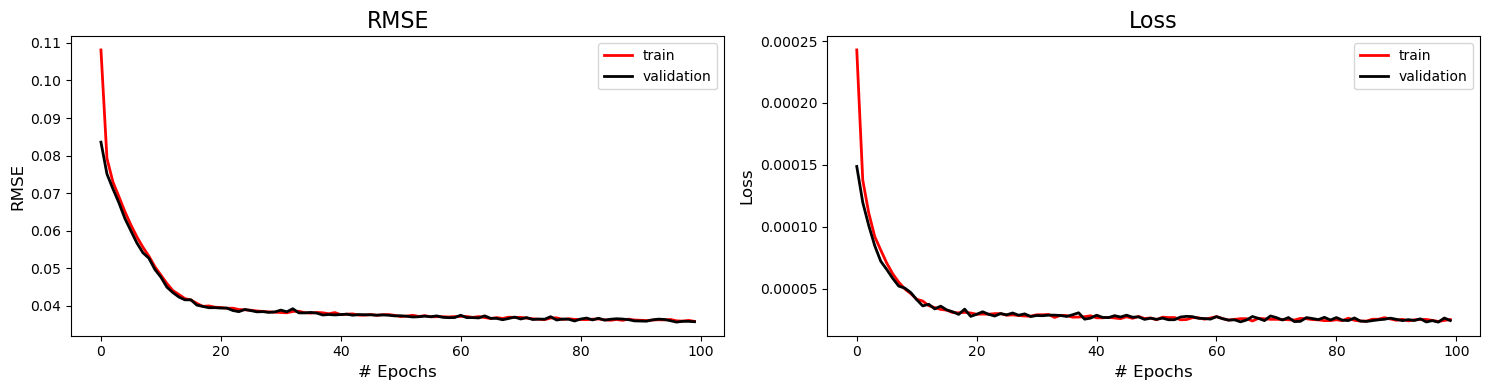

In [18]:
# Plotting trainnig metrics using pre-made function
fig,axs = plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

***

# Run Jacobian Analysis

![alternatvie text](https://onlinelibrary.wiley.com/cms/asset/0d58bc30-3bef-4180-b0fe-210a8b495097/gpr13480-fig-0002-m.jpg)

In [19]:
def single_pix_jacobian_probe(network,
                              testpatch,
                              iy,
                              ix,
                              device,):
    """ Analysis of local weights by probing Jacobian matrix of weights of a single pixel

    Parameters
    ----------
    network : Torch network
        Noisy patch of data to be processed
    testpatch : numpy 2D array
        Noisy patch to be passed to network
    iy : int
        y coordinate of pixel to be used for investigation
    ix : int
        x coordinate of pixel to be used for investigation
    device : torch device
        Device where network computation will occur (e.g., CPU or GPU)
     
    Returns
    -------
        jac_row : numpy 2D array
            Jacobian weights map
    """
    testpatch_grad = torch.from_numpy(np.expand_dims(np.expand_dims(testpatch.astype('float32'), axis=0), axis=0)).to(device)
    testpatch_grad.requires_grad = True

    # Run test dataset through network
    network.to(device)
    network.eval()
    testpatch_prediction = network(testpatch_grad.to(device)).to(device)
    
    # Compute Jacobian Row
    jac_row = torch.autograd.grad(testpatch_prediction[0, 0, iy, ix],
                                  testpatch_grad,
                                  retain_graph=True)[0][0, 0].data.cpu().detach().numpy()

    return jac_row

In [20]:
def multi_pix_jacobian_probe(network, input_image, numpixs, device, maskwin=31):
    """ Analysis of local weights by probing Jacobian matrix of many pixels

    Parameters
    ----------
    network : Torch network
        Noisy patch of data to be processed
    input_image : numpy 2D array
        Noisy input_image to be passed to network
    numpixs : int
        number pixels to be probed for investigation
    device : torch device
        Device where network computation will occur (e.g., CPU or GPU)
    maskwin: int
        size of area to retain Jacobian weights map, centered around probed pixel
    Returns
    -------
        jac_map : numpy 3D array
            Contribution of pixels within mask window
    """
    jac_map = np.zeros([numpixs, maskwin, maskwin])

    # Randomly select x and y pixel locations for analysis
    half_mw = int((maskwin - 1) / 2)
    idx_aps = np.random.randint(15, input_image.shape[1] - half_mw, numpixs)
    idy_aps = np.random.randint(15, input_image.shape[0] - half_mw, numpixs)

    for i in tqdm(range(numpixs)):
        jac_row = single_pix_jacobian_probe(network,
                                   input_image,
                                   idy_aps[i],
                                   idx_aps[i],
                                   device,)

        # Take contribution of neighbouring pixels
        jac_map[i] = jac_row[idy_aps[i] - half_mw:idy_aps[i] + half_mw + 1, idx_aps[i] - half_mw:idx_aps[i] + half_mw + 1]

    return jac_map

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.56it/s]


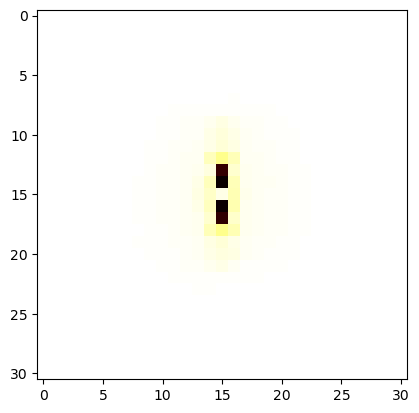

In [21]:
torch_testdata = np.expand_dims(noisydata,1)

BS_Jacobian_Full = multi_pix_jacobian_probe(network, noisydata, numpixs=1000, device=device)
BS_Jacobian_ave = np.mean(abs(BS_Jacobian_Full),axis=0)
plt.imshow(BS_Jacobian_ave, cmap='hot_r', vmin=0, vmax=np.percentile(BS_Jacobian_ave,99.8)
          )

Text(0.5, 1.0, 'Jacobian Mask')

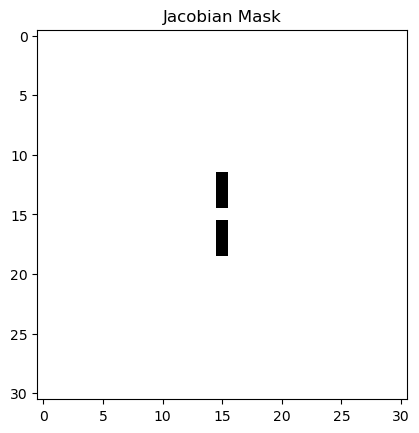

In [22]:
contr_limit = 0.01  # Mask Cut-off
norm_pixcontr = BS_Jacobian_ave/np.sum(BS_Jacobian_ave)

# Mask creation and visualisation
jac_mask = np.zeros_like(BS_Jacobian_ave)
jac_mask[np.where(norm_pixcontr>contr_limit)] = 1
plt.imshow(jac_mask, vmin=0, vmax=1, cmap='binary')
plt.title('Jacobian Mask')

----------------------

# Corrupt using the pre-defined mask

In [23]:
def jacobian_corruption(patch, jac_mask, num_activepixels, mask_window=31, crpt_amp=1e-4):
    """ Function to identify multiple active pixels, place blind-mask and replace masked values from random distribution

    Parameters
    ----------
    patch : numpy 2D array
        Noisy patch of data to be processed
    jac_mask : numpy 2D array
        Mask to be placed at active pixels (AP loc=center of mask)
    num_activepixels : int
        Number of active pixels to be selected within the patch
    mask_window : int
        Size of patch in xy [accounts for pixels choosen near edge of patch]
    crpt_amp : float
        Amplitude limit of random corruption values (centered at zero)
    Returns
    -------
        cp_ptch : numpy 2D array
            Processed patch
        crpt_mask : numpy 2D array
            Mask showing location of masks within the patch
        ap_mask : numpy 2D array
            Mask showing location of active pixels within the patch
    """
    # To enforce active pixel to be masked
    half_win = int(0.5 * (mask_window - 1))
    jac_mask[half_win, half_win] = 1
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP ONE: SELECT ACTIVE PIXEL LOCATIONS
    idx_aps = np.random.randint(0, patch.shape[0], num_activepixels)
    idy_aps = np.random.randint(0, patch.shape[1], num_activepixels)
    id_aps = (idx_aps, idy_aps)

    ap_mask = np.ones_like(patch)
    ap_mask[id_aps] = 0.

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP TWO: MAKE MASK PATCH
    mask_patch_lrg = np.zeros([patch.shape[0] + mask_window, patch.shape[1] + mask_window])
    for i in range(len(idx_aps)):
        apx = idx_aps[i]
        apy = idy_aps[i]
        mask_patch_lrg[apx:apx + mask_window, apy:apy + mask_window] += jac_mask

    mask_patch = mask_patch_lrg[half_win:-half_win - 1, half_win:-half_win - 1]
    mask_patch[np.where(mask_patch > 1)] = 1
    crpt_mask = abs(np.ones_like(mask_patch) - mask_patch)

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP THREE: PERFORM CORRUPTION
    corrupt_patch_noise = (crpt_amp * np.random.randn(crpt_mask.shape[0], crpt_mask.shape[1])) * mask_patch
    corrupt_patch_data = patch * crpt_mask

    return corrupt_patch_noise + corrupt_patch_data, crpt_mask, ap_mask


In [24]:
bm_num_activepixels = 10

crpt_patch, crpt_mask, ap_mask = jacobian_corruption(noisy_patches[0],
                                                     jac_mask,
                                                     num_activepixels=int(bm_num_activepixels), 
                                                     crpt_amp = np.mean(abs(noisy_patches[0])),
                                                     )

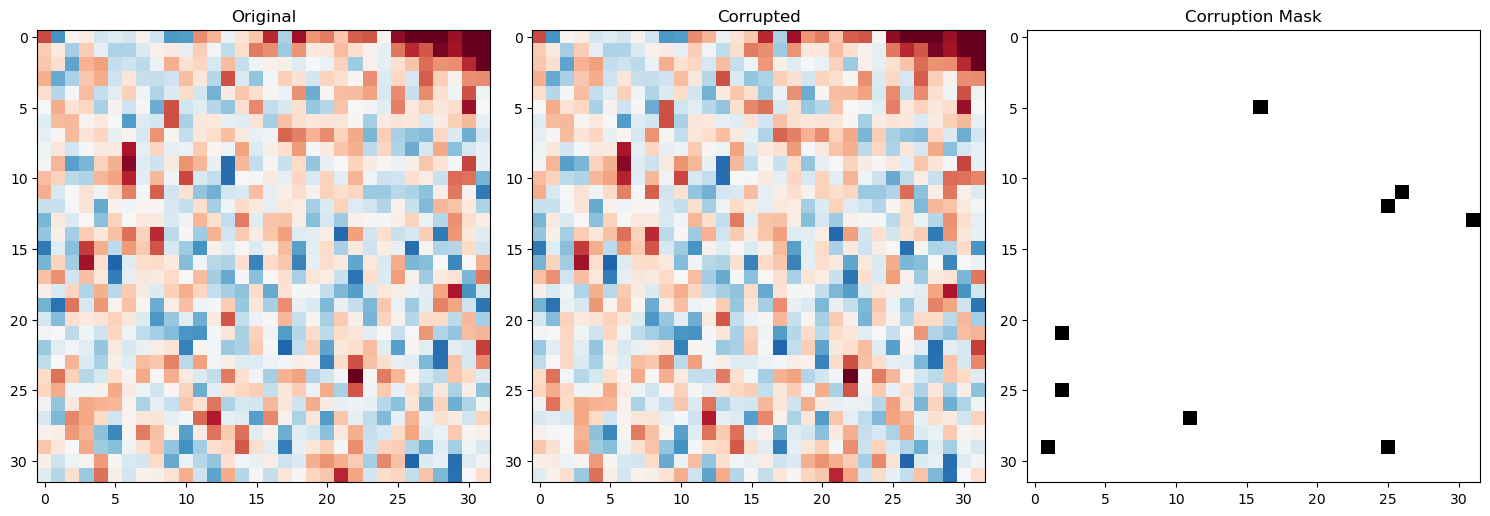

In [25]:
# Use the pre-made plotting function to visualise the corruption
fig,axs = plot_corruption(noisy_patches[0], crpt_patch, ap_mask)

-----------

# Make a new network for blind-mask denoising

In [26]:
# Build UNet from pre-made function
bm_network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
bm_network = bm_network.apply(weights_init) 

/Users/clairebirnie/Documents/Projects/TEACHING/SelfSupervisedDenoising_2024TutorialMaterial/Solutions/tutorial_utils.py:267: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/Users/clairebirnie/Documents/Projects/TEACHING/SelfSupervisedDenoising_2024TutorialMaterial/Solutions/tutorial_utils.py:268: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


In [27]:
# Blindmask epochs
bm_n_epochs = 250
# reinitiate optimiser
optim = torch.optim.Adam(bm_network.parameters(), lr=lr)  # Optimiser

# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(bm_n_epochs)
train_accuracy_history = np.zeros(bm_n_epochs)
test_loss_history = np.zeros(bm_n_epochs)
test_accuracy_history = np.zeros(bm_n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

-------------

# Train with automatically generated blind-mask

In [28]:
# TRAINING
for ep in range(bm_n_epochs):          
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        corrupted_patches[pi], _, masks[pi] = jacobian_corruption(noisy_patches[pi], 
                                                                  jac_mask, 
                                                                  num_activepixels=int(num_activepixels), 
                                                                  crpt_amp = np.mean(abs(noisy_patches[pi])),
                                                                  )
        
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    train_loss, train_accuracy = n2v_train(bm_network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)

    # EVALUATE (AKA VALIDATION)
    test_loss, test_accuracy = n2v_evaluate(bm_network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    
    
    # Keeping track of training/val metrics for later plots
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.27it/s]


Epoch 0, 
    Training Loss 0.0002,     Training Accuracy 0.1082, 
    Test Loss 0.0002,     Test Accuracy 0.0956 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.15it/s]


Epoch 1, 
    Training Loss 0.0002,     Training Accuracy 0.0930, 
    Test Loss 0.0002,     Test Accuracy 0.0902 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.74it/s]


Epoch 2, 
    Training Loss 0.0002,     Training Accuracy 0.0904, 
    Test Loss 0.0002,     Test Accuracy 0.0900 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.38it/s]


Epoch 3, 
    Training Loss 0.0002,     Training Accuracy 0.0906, 
    Test Loss 0.0002,     Test Accuracy 0.0905 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.95it/s]


Epoch 4, 
    Training Loss 0.0002,     Training Accuracy 0.0907, 
    Test Loss 0.0002,     Test Accuracy 0.0905 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.63it/s]


Epoch 5, 
    Training Loss 0.0002,     Training Accuracy 0.0908, 
    Test Loss 0.0002,     Test Accuracy 0.0908 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.07it/s]


Epoch 6, 
    Training Loss 0.0002,     Training Accuracy 0.0907, 
    Test Loss 0.0002,     Test Accuracy 0.0897 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.86it/s]


Epoch 7, 
    Training Loss 0.0002,     Training Accuracy 0.0897, 
    Test Loss 0.0002,     Test Accuracy 0.0891 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.46it/s]


Epoch 8, 
    Training Loss 0.0002,     Training Accuracy 0.0891, 
    Test Loss 0.0002,     Test Accuracy 0.0886 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.91it/s]


Epoch 9, 
    Training Loss 0.0002,     Training Accuracy 0.0891, 
    Test Loss 0.0002,     Test Accuracy 0.0888 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.84it/s]


Epoch 10, 
    Training Loss 0.0002,     Training Accuracy 0.0890, 
    Test Loss 0.0002,     Test Accuracy 0.0880 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.26it/s]


Epoch 11, 
    Training Loss 0.0002,     Training Accuracy 0.0881, 
    Test Loss 0.0001,     Test Accuracy 0.0877 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.73it/s]


Epoch 12, 
    Training Loss 0.0002,     Training Accuracy 0.0880, 
    Test Loss 0.0001,     Test Accuracy 0.0876 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.14it/s]


Epoch 13, 
    Training Loss 0.0001,     Training Accuracy 0.0877, 
    Test Loss 0.0001,     Test Accuracy 0.0870 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.14it/s]


Epoch 14, 
    Training Loss 0.0001,     Training Accuracy 0.0876, 
    Test Loss 0.0001,     Test Accuracy 0.0870 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.08it/s]


Epoch 15, 
    Training Loss 0.0001,     Training Accuracy 0.0871, 
    Test Loss 0.0002,     Test Accuracy 0.0866 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.27it/s]


Epoch 16, 
    Training Loss 0.0001,     Training Accuracy 0.0869, 
    Test Loss 0.0001,     Test Accuracy 0.0869 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


Epoch 17, 
    Training Loss 0.0001,     Training Accuracy 0.0870, 
    Test Loss 0.0001,     Test Accuracy 0.0864 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.49it/s]


Epoch 18, 
    Training Loss 0.0001,     Training Accuracy 0.0866, 
    Test Loss 0.0001,     Test Accuracy 0.0861 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.71it/s]


Epoch 19, 
    Training Loss 0.0001,     Training Accuracy 0.0861, 
    Test Loss 0.0001,     Test Accuracy 0.0864 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.31it/s]


Epoch 20, 
    Training Loss 0.0001,     Training Accuracy 0.0862, 
    Test Loss 0.0001,     Test Accuracy 0.0857 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.53it/s]


Epoch 21, 
    Training Loss 0.0001,     Training Accuracy 0.0859, 
    Test Loss 0.0001,     Test Accuracy 0.0857 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 22, 
    Training Loss 0.0001,     Training Accuracy 0.0856, 
    Test Loss 0.0001,     Test Accuracy 0.0853 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.15it/s]


Epoch 23, 
    Training Loss 0.0001,     Training Accuracy 0.0850, 
    Test Loss 0.0001,     Test Accuracy 0.0843 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.15it/s]


Epoch 24, 
    Training Loss 0.0001,     Training Accuracy 0.0845, 
    Test Loss 0.0001,     Test Accuracy 0.0847 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.45it/s]


Epoch 25, 
    Training Loss 0.0001,     Training Accuracy 0.0850, 
    Test Loss 0.0001,     Test Accuracy 0.0847 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.91it/s]


Epoch 26, 
    Training Loss 0.0001,     Training Accuracy 0.0851, 
    Test Loss 0.0001,     Test Accuracy 0.0849 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.84it/s]


Epoch 27, 
    Training Loss 0.0001,     Training Accuracy 0.0845, 
    Test Loss 0.0001,     Test Accuracy 0.0843 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.61it/s]


Epoch 28, 
    Training Loss 0.0001,     Training Accuracy 0.0840, 
    Test Loss 0.0001,     Test Accuracy 0.0838 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.05it/s]


Epoch 29, 
    Training Loss 0.0001,     Training Accuracy 0.0845, 
    Test Loss 0.0001,     Test Accuracy 0.0848 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.85it/s]


Epoch 30, 
    Training Loss 0.0001,     Training Accuracy 0.0849, 
    Test Loss 0.0001,     Test Accuracy 0.0842 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.01it/s]


Epoch 31, 
    Training Loss 0.0001,     Training Accuracy 0.0842, 
    Test Loss 0.0001,     Test Accuracy 0.0841 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


Epoch 32, 
    Training Loss 0.0001,     Training Accuracy 0.0839, 
    Test Loss 0.0001,     Test Accuracy 0.0840 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.59it/s]


Epoch 33, 
    Training Loss 0.0001,     Training Accuracy 0.0840, 
    Test Loss 0.0001,     Test Accuracy 0.0838 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.78it/s]


Epoch 34, 
    Training Loss 0.0001,     Training Accuracy 0.0840, 
    Test Loss 0.0001,     Test Accuracy 0.0843 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.43it/s]


Epoch 35, 
    Training Loss 0.0001,     Training Accuracy 0.0843, 
    Test Loss 0.0001,     Test Accuracy 0.0839 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


Epoch 36, 
    Training Loss 0.0001,     Training Accuracy 0.0844, 
    Test Loss 0.0001,     Test Accuracy 0.0841 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.25it/s]


Epoch 37, 
    Training Loss 0.0001,     Training Accuracy 0.0842, 
    Test Loss 0.0001,     Test Accuracy 0.0836 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.55it/s]


Epoch 38, 
    Training Loss 0.0001,     Training Accuracy 0.0839, 
    Test Loss 0.0001,     Test Accuracy 0.0840 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.84it/s]


Epoch 39, 
    Training Loss 0.0001,     Training Accuracy 0.0842, 
    Test Loss 0.0001,     Test Accuracy 0.0835 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.01it/s]


Epoch 40, 
    Training Loss 0.0001,     Training Accuracy 0.0834, 
    Test Loss 0.0001,     Test Accuracy 0.0830 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.82it/s]


Epoch 41, 
    Training Loss 0.0001,     Training Accuracy 0.0836, 
    Test Loss 0.0001,     Test Accuracy 0.0834 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.52it/s]


Epoch 42, 
    Training Loss 0.0001,     Training Accuracy 0.0836, 
    Test Loss 0.0001,     Test Accuracy 0.0831 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.28it/s]


Epoch 43, 
    Training Loss 0.0001,     Training Accuracy 0.0834, 
    Test Loss 0.0001,     Test Accuracy 0.0836 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.62it/s]


Epoch 44, 
    Training Loss 0.0001,     Training Accuracy 0.0836, 
    Test Loss 0.0001,     Test Accuracy 0.0836 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.38it/s]


Epoch 45, 
    Training Loss 0.0001,     Training Accuracy 0.0836, 
    Test Loss 0.0001,     Test Accuracy 0.0835 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.40it/s]


Epoch 46, 
    Training Loss 0.0001,     Training Accuracy 0.0831, 
    Test Loss 0.0001,     Test Accuracy 0.0829 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.47it/s]


Epoch 47, 
    Training Loss 0.0001,     Training Accuracy 0.0835, 
    Test Loss 0.0001,     Test Accuracy 0.0832 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.84it/s]


Epoch 48, 
    Training Loss 0.0001,     Training Accuracy 0.0832, 
    Test Loss 0.0001,     Test Accuracy 0.0830 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.30it/s]


Epoch 49, 
    Training Loss 0.0001,     Training Accuracy 0.0831, 
    Test Loss 0.0001,     Test Accuracy 0.0833 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.47it/s]


Epoch 50, 
    Training Loss 0.0001,     Training Accuracy 0.0834, 
    Test Loss 0.0001,     Test Accuracy 0.0827 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.92it/s]


Epoch 51, 
    Training Loss 0.0001,     Training Accuracy 0.0828, 
    Test Loss 0.0001,     Test Accuracy 0.0827 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.83it/s]


Epoch 52, 
    Training Loss 0.0001,     Training Accuracy 0.0830, 
    Test Loss 0.0001,     Test Accuracy 0.0829 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.00it/s]


Epoch 53, 
    Training Loss 0.0001,     Training Accuracy 0.0830, 
    Test Loss 0.0001,     Test Accuracy 0.0827 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.39it/s]


Epoch 54, 
    Training Loss 0.0001,     Training Accuracy 0.0829, 
    Test Loss 0.0001,     Test Accuracy 0.0828 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.11it/s]


Epoch 55, 
    Training Loss 0.0001,     Training Accuracy 0.0827, 
    Test Loss 0.0001,     Test Accuracy 0.0827 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.27it/s]


Epoch 56, 
    Training Loss 0.0001,     Training Accuracy 0.0831, 
    Test Loss 0.0001,     Test Accuracy 0.0844 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.18it/s]


Epoch 57, 
    Training Loss 0.0001,     Training Accuracy 0.0830, 
    Test Loss 0.0001,     Test Accuracy 0.0829 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.53it/s]


Epoch 58, 
    Training Loss 0.0001,     Training Accuracy 0.0831, 
    Test Loss 0.0001,     Test Accuracy 0.0828 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.32it/s]


Epoch 59, 
    Training Loss 0.0001,     Training Accuracy 0.0828, 
    Test Loss 0.0001,     Test Accuracy 0.0829 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.42it/s]


Epoch 60, 
    Training Loss 0.0001,     Training Accuracy 0.0831, 
    Test Loss 0.0001,     Test Accuracy 0.0831 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.76it/s]


Epoch 61, 
    Training Loss 0.0001,     Training Accuracy 0.0833, 
    Test Loss 0.0001,     Test Accuracy 0.0833 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.68it/s]


Epoch 62, 
    Training Loss 0.0001,     Training Accuracy 0.0832, 
    Test Loss 0.0001,     Test Accuracy 0.0828 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.31it/s]


Epoch 63, 
    Training Loss 0.0001,     Training Accuracy 0.0827, 
    Test Loss 0.0001,     Test Accuracy 0.0826 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.16it/s]


Epoch 64, 
    Training Loss 0.0001,     Training Accuracy 0.0829, 
    Test Loss 0.0001,     Test Accuracy 0.0829 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


Epoch 65, 
    Training Loss 0.0001,     Training Accuracy 0.0827, 
    Test Loss 0.0001,     Test Accuracy 0.0826 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


Epoch 66, 
    Training Loss 0.0001,     Training Accuracy 0.0825, 
    Test Loss 0.0001,     Test Accuracy 0.0824 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.40it/s]


Epoch 67, 
    Training Loss 0.0001,     Training Accuracy 0.0827, 
    Test Loss 0.0001,     Test Accuracy 0.0830 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.56it/s]


Epoch 68, 
    Training Loss 0.0001,     Training Accuracy 0.0824, 
    Test Loss 0.0001,     Test Accuracy 0.0823 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.61it/s]


Epoch 69, 
    Training Loss 0.0001,     Training Accuracy 0.0824, 
    Test Loss 0.0001,     Test Accuracy 0.0824 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.57it/s]


Epoch 70, 
    Training Loss 0.0001,     Training Accuracy 0.0826, 
    Test Loss 0.0001,     Test Accuracy 0.0826 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


Epoch 71, 
    Training Loss 0.0001,     Training Accuracy 0.0827, 
    Test Loss 0.0001,     Test Accuracy 0.0827 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.15it/s]


Epoch 72, 
    Training Loss 0.0001,     Training Accuracy 0.0825, 
    Test Loss 0.0001,     Test Accuracy 0.0830 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


Epoch 73, 
    Training Loss 0.0001,     Training Accuracy 0.0828, 
    Test Loss 0.0001,     Test Accuracy 0.0825 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.47it/s]


Epoch 74, 
    Training Loss 0.0001,     Training Accuracy 0.0820, 
    Test Loss 0.0001,     Test Accuracy 0.0824 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.62it/s]


Epoch 75, 
    Training Loss 0.0001,     Training Accuracy 0.0823, 
    Test Loss 0.0001,     Test Accuracy 0.0822 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.23it/s]


Epoch 76, 
    Training Loss 0.0001,     Training Accuracy 0.0820, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


Epoch 77, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0817 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.74it/s]


Epoch 78, 
    Training Loss 0.0001,     Training Accuracy 0.0821, 
    Test Loss 0.0001,     Test Accuracy 0.0821 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.31it/s]


Epoch 79, 
    Training Loss 0.0001,     Training Accuracy 0.0821, 
    Test Loss 0.0001,     Test Accuracy 0.0820 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.49it/s]


Epoch 80, 
    Training Loss 0.0001,     Training Accuracy 0.0824, 
    Test Loss 0.0001,     Test Accuracy 0.0821 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.29it/s]


Epoch 81, 
    Training Loss 0.0001,     Training Accuracy 0.0820, 
    Test Loss 0.0001,     Test Accuracy 0.0820 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


Epoch 82, 
    Training Loss 0.0001,     Training Accuracy 0.0820, 
    Test Loss 0.0001,     Test Accuracy 0.0818 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.62it/s]


Epoch 83, 
    Training Loss 0.0001,     Training Accuracy 0.0817, 
    Test Loss 0.0001,     Test Accuracy 0.0818 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.38it/s]


Epoch 84, 
    Training Loss 0.0001,     Training Accuracy 0.0821, 
    Test Loss 0.0001,     Test Accuracy 0.0828 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.36it/s]


Epoch 85, 
    Training Loss 0.0001,     Training Accuracy 0.0825, 
    Test Loss 0.0001,     Test Accuracy 0.0823 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.56it/s]


Epoch 86, 
    Training Loss 0.0001,     Training Accuracy 0.0825, 
    Test Loss 0.0001,     Test Accuracy 0.0825 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.16it/s]


Epoch 87, 
    Training Loss 0.0001,     Training Accuracy 0.0819, 
    Test Loss 0.0001,     Test Accuracy 0.0821 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.63it/s]


Epoch 88, 
    Training Loss 0.0001,     Training Accuracy 0.0820, 
    Test Loss 0.0001,     Test Accuracy 0.0822 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.60it/s]


Epoch 89, 
    Training Loss 0.0001,     Training Accuracy 0.0819, 
    Test Loss 0.0001,     Test Accuracy 0.0813 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.90it/s]


Epoch 90, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.11it/s]


Epoch 91, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.20it/s]


Epoch 92, 
    Training Loss 0.0001,     Training Accuracy 0.0817, 
    Test Loss 0.0001,     Test Accuracy 0.0822 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.47it/s]


Epoch 93, 
    Training Loss 0.0001,     Training Accuracy 0.0821, 
    Test Loss 0.0001,     Test Accuracy 0.0825 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.98it/s]


Epoch 94, 
    Training Loss 0.0001,     Training Accuracy 0.0825, 
    Test Loss 0.0001,     Test Accuracy 0.0824 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.51it/s]


Epoch 95, 
    Training Loss 0.0001,     Training Accuracy 0.0821, 
    Test Loss 0.0001,     Test Accuracy 0.0819 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.81it/s]


Epoch 96, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


Epoch 97, 
    Training Loss 0.0001,     Training Accuracy 0.0817, 
    Test Loss 0.0001,     Test Accuracy 0.0822 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.35it/s]


Epoch 98, 
    Training Loss 0.0001,     Training Accuracy 0.0822, 
    Test Loss 0.0001,     Test Accuracy 0.0824 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.52it/s]


Epoch 99, 
    Training Loss 0.0001,     Training Accuracy 0.0823, 
    Test Loss 0.0001,     Test Accuracy 0.0821 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


Epoch 100, 
    Training Loss 0.0001,     Training Accuracy 0.0819, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.27it/s]


Epoch 101, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0818 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.92it/s]


Epoch 102, 
    Training Loss 0.0001,     Training Accuracy 0.0817, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.42it/s]


Epoch 103, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0820 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


Epoch 104, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.25it/s]


Epoch 105, 
    Training Loss 0.0001,     Training Accuracy 0.0818, 
    Test Loss 0.0001,     Test Accuracy 0.0818 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.01it/s]


Epoch 106, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.22it/s]


Epoch 107, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 108, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0818 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.27it/s]


Epoch 109, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.05it/s]


Epoch 110, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.49it/s]


Epoch 111, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.08it/s]


Epoch 112, 
    Training Loss 0.0001,     Training Accuracy 0.0815, 
    Test Loss 0.0001,     Test Accuracy 0.0822 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.19it/s]


Epoch 113, 
    Training Loss 0.0001,     Training Accuracy 0.0819, 
    Test Loss 0.0001,     Test Accuracy 0.0817 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.79it/s]


Epoch 114, 
    Training Loss 0.0001,     Training Accuracy 0.0815, 
    Test Loss 0.0001,     Test Accuracy 0.0818 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.39it/s]


Epoch 115, 
    Training Loss 0.0001,     Training Accuracy 0.0820, 
    Test Loss 0.0001,     Test Accuracy 0.0823 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.31it/s]


Epoch 116, 
    Training Loss 0.0001,     Training Accuracy 0.0820, 
    Test Loss 0.0001,     Test Accuracy 0.0820 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.70it/s]


Epoch 117, 
    Training Loss 0.0001,     Training Accuracy 0.0819, 
    Test Loss 0.0001,     Test Accuracy 0.0819 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.29it/s]


Epoch 118, 
    Training Loss 0.0001,     Training Accuracy 0.0815, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


Epoch 119, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0818 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.41it/s]


Epoch 120, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 121, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0819 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.39it/s]


Epoch 122, 
    Training Loss 0.0001,     Training Accuracy 0.0818, 
    Test Loss 0.0001,     Test Accuracy 0.0818 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.30it/s]


Epoch 123, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0821 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.30it/s]


Epoch 124, 
    Training Loss 0.0001,     Training Accuracy 0.0817, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.22it/s]


Epoch 125, 
    Training Loss 0.0001,     Training Accuracy 0.0810, 
    Test Loss 0.0001,     Test Accuracy 0.0812 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.09it/s]


Epoch 126, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0823 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.77it/s]


Epoch 127, 
    Training Loss 0.0001,     Training Accuracy 0.0820, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.16it/s]


Epoch 128, 
    Training Loss 0.0001,     Training Accuracy 0.0815, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.42it/s]


Epoch 129, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0813 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.10it/s]


Epoch 130, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.40it/s]


Epoch 131, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0812 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.39it/s]


Epoch 132, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.09it/s]


Epoch 133, 
    Training Loss 0.0001,     Training Accuracy 0.0815, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.60it/s]


Epoch 134, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.83it/s]


Epoch 135, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


Epoch 136, 
    Training Loss 0.0001,     Training Accuracy 0.0817, 
    Test Loss 0.0001,     Test Accuracy 0.0812 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.11it/s]


Epoch 137, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0813 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


Epoch 138, 
    Training Loss 0.0001,     Training Accuracy 0.0808, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.71it/s]


Epoch 139, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.58it/s]


Epoch 140, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0820 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.49it/s]


Epoch 141, 
    Training Loss 0.0001,     Training Accuracy 0.0818, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


Epoch 142, 
    Training Loss 0.0001,     Training Accuracy 0.0817, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.62it/s]


Epoch 143, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.23it/s]


Epoch 144, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.44it/s]


Epoch 145, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.95it/s]


Epoch 146, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.76it/s]


Epoch 147, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0810 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.56it/s]


Epoch 148, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0813 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.41it/s]


Epoch 149, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.07it/s]


Epoch 150, 
    Training Loss 0.0001,     Training Accuracy 0.0815, 
    Test Loss 0.0001,     Test Accuracy 0.0817 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


Epoch 151, 
    Training Loss 0.0001,     Training Accuracy 0.0817, 
    Test Loss 0.0001,     Test Accuracy 0.0823 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.77it/s]


Epoch 152, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0809 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.36it/s]


Epoch 153, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0819 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.34it/s]


Epoch 154, 
    Training Loss 0.0001,     Training Accuracy 0.0810, 
    Test Loss 0.0001,     Test Accuracy 0.0810 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


Epoch 155, 
    Training Loss 0.0001,     Training Accuracy 0.0808, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.97it/s]


Epoch 156, 
    Training Loss 0.0001,     Training Accuracy 0.0805, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 157, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0810 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.39it/s]


Epoch 158, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0820 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


Epoch 159, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.47it/s]


Epoch 160, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0810 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.33it/s]


Epoch 161, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0820 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


Epoch 162, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0808 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.49it/s]


Epoch 163, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.36it/s]


Epoch 164, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.49it/s]


Epoch 165, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0810 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.35it/s]


Epoch 166, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.54it/s]


Epoch 167, 
    Training Loss 0.0001,     Training Accuracy 0.0808, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.49it/s]


Epoch 168, 
    Training Loss 0.0001,     Training Accuracy 0.0805, 
    Test Loss 0.0001,     Test Accuracy 0.0813 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.85it/s]


Epoch 169, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


Epoch 170, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.35it/s]


Epoch 171, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0810 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.30it/s]


Epoch 172, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.32it/s]


Epoch 173, 
    Training Loss 0.0001,     Training Accuracy 0.0815, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.43it/s]


Epoch 174, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


Epoch 175, 
    Training Loss 0.0001,     Training Accuracy 0.0811, 
    Test Loss 0.0001,     Test Accuracy 0.0813 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.60it/s]


Epoch 176, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.75it/s]


Epoch 177, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0809 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.75it/s]


Epoch 178, 
    Training Loss 0.0001,     Training Accuracy 0.0808, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.78it/s]


Epoch 179, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.06it/s]


Epoch 180, 
    Training Loss 0.0001,     Training Accuracy 0.0803, 
    Test Loss 0.0001,     Test Accuracy 0.0801 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.08it/s]


Epoch 181, 
    Training Loss 0.0001,     Training Accuracy 0.0802, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.01it/s]


Epoch 182, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


Epoch 183, 
    Training Loss 0.0001,     Training Accuracy 0.0805, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.49it/s]


Epoch 184, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.84it/s]


Epoch 185, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0812 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.57it/s]


Epoch 186, 
    Training Loss 0.0001,     Training Accuracy 0.0810, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.32it/s]


Epoch 187, 
    Training Loss 0.0001,     Training Accuracy 0.0810, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.47it/s]


Epoch 188, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


Epoch 189, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0812 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


Epoch 190, 
    Training Loss 0.0001,     Training Accuracy 0.0805, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


Epoch 191, 
    Training Loss 0.0001,     Training Accuracy 0.0804, 
    Test Loss 0.0001,     Test Accuracy 0.0803 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.10it/s]


Epoch 192, 
    Training Loss 0.0001,     Training Accuracy 0.0801, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.02it/s]


Epoch 193, 
    Training Loss 0.0001,     Training Accuracy 0.0803, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.33it/s]


Epoch 194, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0812 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.43it/s]


Epoch 195, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0812 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.04it/s]


Epoch 196, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0809 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.51it/s]


Epoch 197, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.03it/s]


Epoch 198, 
    Training Loss 0.0001,     Training Accuracy 0.0811, 
    Test Loss 0.0001,     Test Accuracy 0.0805 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.71it/s]


Epoch 199, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


Epoch 200, 
    Training Loss 0.0001,     Training Accuracy 0.0802, 
    Test Loss 0.0001,     Test Accuracy 0.0804 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


Epoch 201, 
    Training Loss 0.0001,     Training Accuracy 0.0805, 
    Test Loss 0.0001,     Test Accuracy 0.0808 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


Epoch 202, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0809 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.10it/s]


Epoch 203, 
    Training Loss 0.0001,     Training Accuracy 0.0805, 
    Test Loss 0.0001,     Test Accuracy 0.0808 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.23it/s]


Epoch 204, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0810 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


Epoch 205, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0805 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.62it/s]


Epoch 206, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


Epoch 207, 
    Training Loss 0.0001,     Training Accuracy 0.0803, 
    Test Loss 0.0001,     Test Accuracy 0.0804 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


Epoch 208, 
    Training Loss 0.0001,     Training Accuracy 0.0800, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.72it/s]


Epoch 209, 
    Training Loss 0.0001,     Training Accuracy 0.0804, 
    Test Loss 0.0001,     Test Accuracy 0.0801 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.65it/s]


Epoch 210, 
    Training Loss 0.0001,     Training Accuracy 0.0803, 
    Test Loss 0.0001,     Test Accuracy 0.0810 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.44it/s]


Epoch 211, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


Epoch 212, 
    Training Loss 0.0001,     Training Accuracy 0.0804, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.60it/s]


Epoch 213, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0805 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.43it/s]


Epoch 214, 
    Training Loss 0.0001,     Training Accuracy 0.0805, 
    Test Loss 0.0001,     Test Accuracy 0.0812 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.51it/s]


Epoch 215, 
    Training Loss 0.0001,     Training Accuracy 0.0813, 
    Test Loss 0.0001,     Test Accuracy 0.0814 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.48it/s]


Epoch 216, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0804 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.91it/s]


Epoch 217, 
    Training Loss 0.0001,     Training Accuracy 0.0804, 
    Test Loss 0.0001,     Test Accuracy 0.0809 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.43it/s]


Epoch 218, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0808 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.37it/s]


Epoch 219, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.31it/s]


Epoch 220, 
    Training Loss 0.0001,     Training Accuracy 0.0806, 
    Test Loss 0.0001,     Test Accuracy 0.0805 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.63it/s]


Epoch 221, 
    Training Loss 0.0001,     Training Accuracy 0.0803, 
    Test Loss 0.0001,     Test Accuracy 0.0821 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.45it/s]


Epoch 222, 
    Training Loss 0.0001,     Training Accuracy 0.0812, 
    Test Loss 0.0001,     Test Accuracy 0.0818 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


Epoch 223, 
    Training Loss 0.0001,     Training Accuracy 0.0811, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.70it/s]


Epoch 224, 
    Training Loss 0.0001,     Training Accuracy 0.0803, 
    Test Loss 0.0001,     Test Accuracy 0.0809 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.48it/s]


Epoch 225, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0807 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


Epoch 226, 
    Training Loss 0.0001,     Training Accuracy 0.0800, 
    Test Loss 0.0001,     Test Accuracy 0.0803 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.33it/s]


Epoch 227, 
    Training Loss 0.0001,     Training Accuracy 0.0803, 
    Test Loss 0.0001,     Test Accuracy 0.0804 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


Epoch 228, 
    Training Loss 0.0001,     Training Accuracy 0.0798, 
    Test Loss 0.0001,     Test Accuracy 0.0804 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


Epoch 229, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0817 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.33it/s]


Epoch 230, 
    Training Loss 0.0001,     Training Accuracy 0.0809, 
    Test Loss 0.0001,     Test Accuracy 0.0809 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.62it/s]


Epoch 231, 
    Training Loss 0.0001,     Training Accuracy 0.0804, 
    Test Loss 0.0001,     Test Accuracy 0.0802 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.89it/s]


Epoch 232, 
    Training Loss 0.0001,     Training Accuracy 0.0804, 
    Test Loss 0.0001,     Test Accuracy 0.0812 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


Epoch 233, 
    Training Loss 0.0001,     Training Accuracy 0.0802, 
    Test Loss 0.0001,     Test Accuracy 0.0800 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.58it/s]


Epoch 234, 
    Training Loss 0.0001,     Training Accuracy 0.0798, 
    Test Loss 0.0001,     Test Accuracy 0.0803 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.04it/s]


Epoch 235, 
    Training Loss 0.0001,     Training Accuracy 0.0804, 
    Test Loss 0.0001,     Test Accuracy 0.0818 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.71it/s]


Epoch 236, 
    Training Loss 0.0001,     Training Accuracy 0.0808, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.82it/s]


Epoch 237, 
    Training Loss 0.0001,     Training Accuracy 0.0808, 
    Test Loss 0.0001,     Test Accuracy 0.0810 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.37it/s]


Epoch 238, 
    Training Loss 0.0001,     Training Accuracy 0.0802, 
    Test Loss 0.0001,     Test Accuracy 0.0796 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.66it/s]


Epoch 239, 
    Training Loss 0.0001,     Training Accuracy 0.0793, 
    Test Loss 0.0001,     Test Accuracy 0.0796 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


Epoch 240, 
    Training Loss 0.0001,     Training Accuracy 0.0799, 
    Test Loss 0.0001,     Test Accuracy 0.0805 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.38it/s]


Epoch 241, 
    Training Loss 0.0001,     Training Accuracy 0.0805, 
    Test Loss 0.0001,     Test Accuracy 0.0805 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.37it/s]


Epoch 242, 
    Training Loss 0.0001,     Training Accuracy 0.0801, 
    Test Loss 0.0001,     Test Accuracy 0.0804 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.35it/s]


Epoch 243, 
    Training Loss 0.0001,     Training Accuracy 0.0803, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.34it/s]


Epoch 244, 
    Training Loss 0.0001,     Training Accuracy 0.0803, 
    Test Loss 0.0001,     Test Accuracy 0.0813 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 245, 
    Training Loss 0.0001,     Training Accuracy 0.0808, 
    Test Loss 0.0001,     Test Accuracy 0.0804 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.72it/s]


Epoch 246, 
    Training Loss 0.0001,     Training Accuracy 0.0803, 
    Test Loss 0.0001,     Test Accuracy 0.0806 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.31it/s]


Epoch 247, 
    Training Loss 0.0001,     Training Accuracy 0.0804, 
    Test Loss 0.0001,     Test Accuracy 0.0803 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.24it/s]


Epoch 248, 
    Training Loss 0.0001,     Training Accuracy 0.0797, 
    Test Loss 0.0001,     Test Accuracy 0.0799 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.93it/s]


Epoch 249, 
    Training Loss 0.0001,     Training Accuracy 0.0798, 
    Test Loss 0.0001,     Test Accuracy 0.0798 


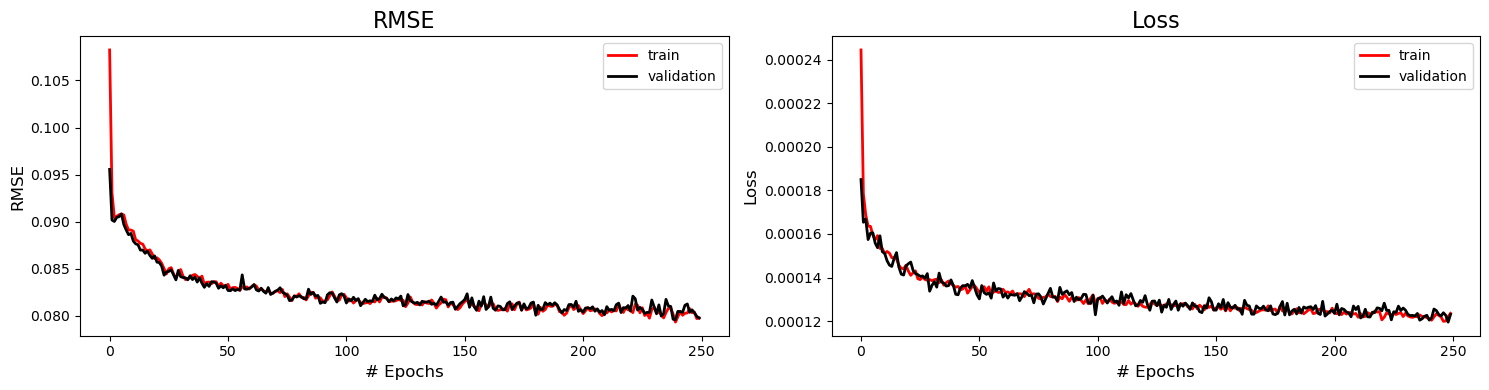

In [29]:
# Plotting trainnig metrics using pre-made function
fig,axs = plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

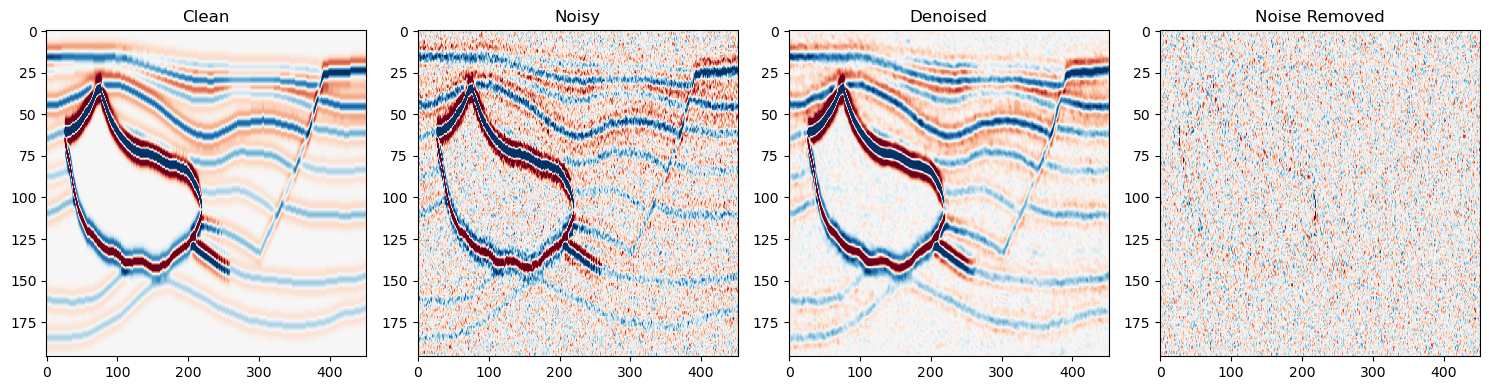

In [31]:
# Make a new noisy realisation so it's different from the training set but with roughly same level of noise
testdata, _ = add_bandlimited_noise(d, sc=0.1)

# Convert dataset in tensor for prediction purposes
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()

# Run test dataset through network
bm_network.eval()
test_prediction = bm_network(torch_testdata.to(device))

# Return to numpy for plotting purposes
test_pred = test_prediction.detach().cpu().numpy().squeeze()

# Use pre-made plotting function to visualise denoising performance
fig,axs = plot_synth_results(d, testdata, test_pred)